# Libraries

In [2]:
import csv
import os
import json
import umap
import textacy
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Articles

In [3]:
articles = []

dir = "data/biomass/"
files = os.listdir(dir)  # Set folder and files

for filename in files:

    f = open(dir + filename)
    r = f.read()
    data = json.loads(r)

    # Parse

    try:

        year = int(data[0]["publish_date"].split(" ")[0].split("-")[0])  # Set year

        title = data[0]["title"]  # Title
        
        url = data[0]["url"]  # URL
        if any(x in url for x in {"feeds.", "rss.", "briefing"}): continue  # Blacklist (Bob Dylan's case)

        entities = data[0]["story_tags"]  # Set sentities
        if len(entities) > 100: continue  # Filter max
        if len(entities) <= 1: continue  # Filter min

        subjects = []
        orgs = []
        people = []

        for entity in entities:

            name = entity["tag"]

            if name[0] == "—": continue  # Remove listings
            if name.startswith("geonames_"): continue  # Skip geotag
            if "readability" in name: continue  # Clean
            if "cliff_clavin_" in name: continue  # Clean
            if "nyt_labeller" in name: continue  # Clean

            name = " ".join(name.split())  # Merge multiple spaces
            name = name.replace(".", "")  # Remove dots
            name = name.replace(",", "")  # Remove commas

            if entity["tag_set"] == "nyt_labels":
                subjects.append(name)

            elif entity["tag_set"] == "cliff_organizations":
                if name.startswith("US "): name = name[3:]  # Remove prefix
                if name.endswith(" Corp"): name = name[:-5]  # Remive postfix
                if name.endswith(" Inc"): name = name[:-4]  # Remive postfix
                if name.endswith(" LCC"): name = name[:-4]  # Remive postfix
                if name[0].islower(): continue  # Remove lowercase
                if name[1].isupper(): continue  # Remove acronyms
                orgs.append(name)

            elif entity["tag_set"] == "cliff_people":
                if "/" in name: continue  # Clean
                if name[1].isupper(): continue  # Remove uppercase
                if name[0].islower(): continue  # Remove lowercase
                if len(name.split(" ")) == 1: continue  # remove those with no family name
                people.append(name)

        if len(orgs) > 0 and len(subjects) > 0:
            articles.append(
                [
                    year,
                    title,
                    url,
                    list(set(subjects)),
                    list(set(orgs)),
                    list(set(people)),
                ]
            ) # Add these articles with actors only

    except:
        continue  # In case of error



articles = pd.DataFrame(
    articles, columns=["year", "title", "url", "subjects", "orgs", "people"]
).drop_duplicates(subset=["url"])  # Remove articles with the same URL

print('The number of articles is ' + str(articles.shape[0]))

articles.sample(1)


The number of articles is 18153


,year,title,url,subjects,orgs,people
5786,2015,Humans are now a unique class of ‘super-predat...,http://feedproxy.google.com/~r/NP_Top_Stories/...,"[animals, research]","[University of Victoria, Raincoast Conservatio...","[Chris Darimont, Tom Reimchen]"


## Entities

In [26]:
entities = np.empty((0, 12), dtype=object)

years_template = { 2011:0, 2012:0, 2013:0, 2014:0, 2015:0, 2016:0, 2017:0, 2018:0, 2019:0, 2020:0 }

def update(entity, type): # Function for writing

    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        -1,
                        -1,
                        -1,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in articles.iterrows(): # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]
    cooccurrences = list(set(row["subjects"] + row["orgs"] + row["people"]))

    for entity in row["subjects"]:
        update(entity, "subject")

    for entity in row["orgs"]:
        update(entity, "org")
      
    for entity in row["people"]:
        update(entity, "person")

# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype({
    "name": "str",
    "type": "str",
    "frequency": "int",
    "slope": "float",
    "color": "str",
    "x": "int",
    "y": "int",
    "cluster": "int",
    "years": "object",
    "urls": "object",
    "titles": "object",
    "cooccurrences": "object",
})


print('The total number of entities is', len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)


The total number of entities is 68338


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
14,environment,subject,7515,NaN,None,-1,-1,-1,"{2011: 184, 2012: 147, 2013: 355, 2014: 489, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[Sunil Dahiya, Indian Institute of Tropical Me..."


# Treatment

## Frequency Scale

In [27]:
frequency = entities_all['frequency'].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
entities_all['frequency_norm'] = frequency_scaled

entities_all.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
8948,Monali Rahalkar,person,4,NaN,None,-1,-1,-1,"{2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, ...",[https://www.thehindu.com/news/national/lonar-...,[Lonar lake turned pink due to ‘Haloarchaea’ m...,"[Prashant Dhakephalkar, travel and vacations, ...",0.000399


## Filter

In [116]:
n = 50 # Number of rows by type

top_subjects = entities_all.loc[entities_all['type'] == 'subject'].sort_values(by=["frequency"], ascending=False).head(n * 3)
top_orgs = entities_all.loc[entities_all['type'] == 'org'].sort_values(by=["frequency"], ascending=False).head(n)
top_people = entities_all.loc[entities_all['type'] == 'person'].sort_values(by=["frequency"], ascending=False).head(n)

entities = pd.concat([top_subjects, top_orgs, top_people])

entities.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
2407,awards decorations and honors,subject,57,NaN,None,-1,-1,-1,"{2011: 0, 2012: 2, 2013: 2, 2014: 1, 2015: 4, ...",[https://news.mongabay.com/2018/04/meet-the-wi...,[Meet the winners of the 2018 Goldman Environm...,"[Goldman Environment Prize, Makoma Lekalakala,...",0.007453


## Linear Regression

In [117]:
# For each

for i, row in entities.iterrows():
    
    x = list(row['years'].keys())
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row['years'].values())

    regression = LinearRegression()
    regression.fit(x, y)

    slope = regression.coef_[0]
    entities.at[i, 'slope'] = slope


# Average and slope difference for subjects

entities_subjects = entities.loc[entities['type'] == 'subject']
average_subjects = entities_subjects['slope'].mean()
for i, row in entities_subjects.iterrows():
    entities.at[i, 'slope'] = row['slope'] - average_subjects


# Average and slope difference for people and organizations

entities_nosubjects = entities.loc[entities['type'] != 'subject']
average_nosubjects = entities_nosubjects['slope'].mean()
for i, row in entities_nosubjects.iterrows():
    entities.at[i, 'slope'] = row['slope'] - average_nosubjects


# entities.sort_values(by=["slope"], ascending=False).head(1)
# average_subjects, average_nosubjects
entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
778,Prakash Javadekar,person,139,0.842242,None,-1,-1,-1,"{2011: 0, 2012: 0, 2013: 0, 2014: 7, 2015: 37,...",[https://www.indiatoday.in/india/story/4-capsu...,"[4 capsules, 20 rupees: Solution to crop burni...","[agriculture, Punjab Energy Development Agency...",0.018366


## Colors

In [118]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():
    
    if row['type'] != 'subject':
        entities.at[i, 'color'] = mcolors.to_hex(cmap(norm(row['slope']))) # Actors
    else:
        entities.at[i, 'color'] = '#CCCCCC' # Subjects

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
14,environment,subject,7515,150.516808,#CCCCCC,-1,-1,-1,"{2011: 184, 2012: 147, 2013: 355, 2014: 489, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[Sunil Dahiya, Indian Institute of Tropical Me...",1.0


# Embedding

## Term Frequency

In [119]:


doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(
    # entities["cooccurrences"].tolist(), tf_type="linear", idf_type="standard"
    entities["cooccurrences"].tolist(), tf_type="linear", idf_type="smooth"
)

list(dictionary.items())[:5]


[('Sunil Dahiya', 59569),
 ('Indian Institute of Tropical Meteorology', 27615),
 ('Karan Madan', 33352),
 ('Imperial College of London', 27442),
 ('Bhure Lal', 7089)]

## UMAP

In [120]:
reducer = umap.UMAP(
    random_state=42,
    n_components=2,
    n_neighbors=4,
    min_dist=0.2,
    metric="hellinger",
)

embedding = reducer.fit_transform(doc_term_matrix)  # Reducer
embedding = align_points_to_grid(embedding) # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

entities.sample(1)


 * creating mesh with size 50 50
 * filling mesh


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
4722,Green Party,org,86,-0.509273,#8badfd,308,720,-1,"{2011: 3, 2012: 1, 2013: 2, 2014: 4, 2015: 3, ...",[https://www.walesonline.co.uk/news/politics/g...,[700 million trees; radical housing plans: The...,"[Lib, politics and government, energy and powe...",0.011312


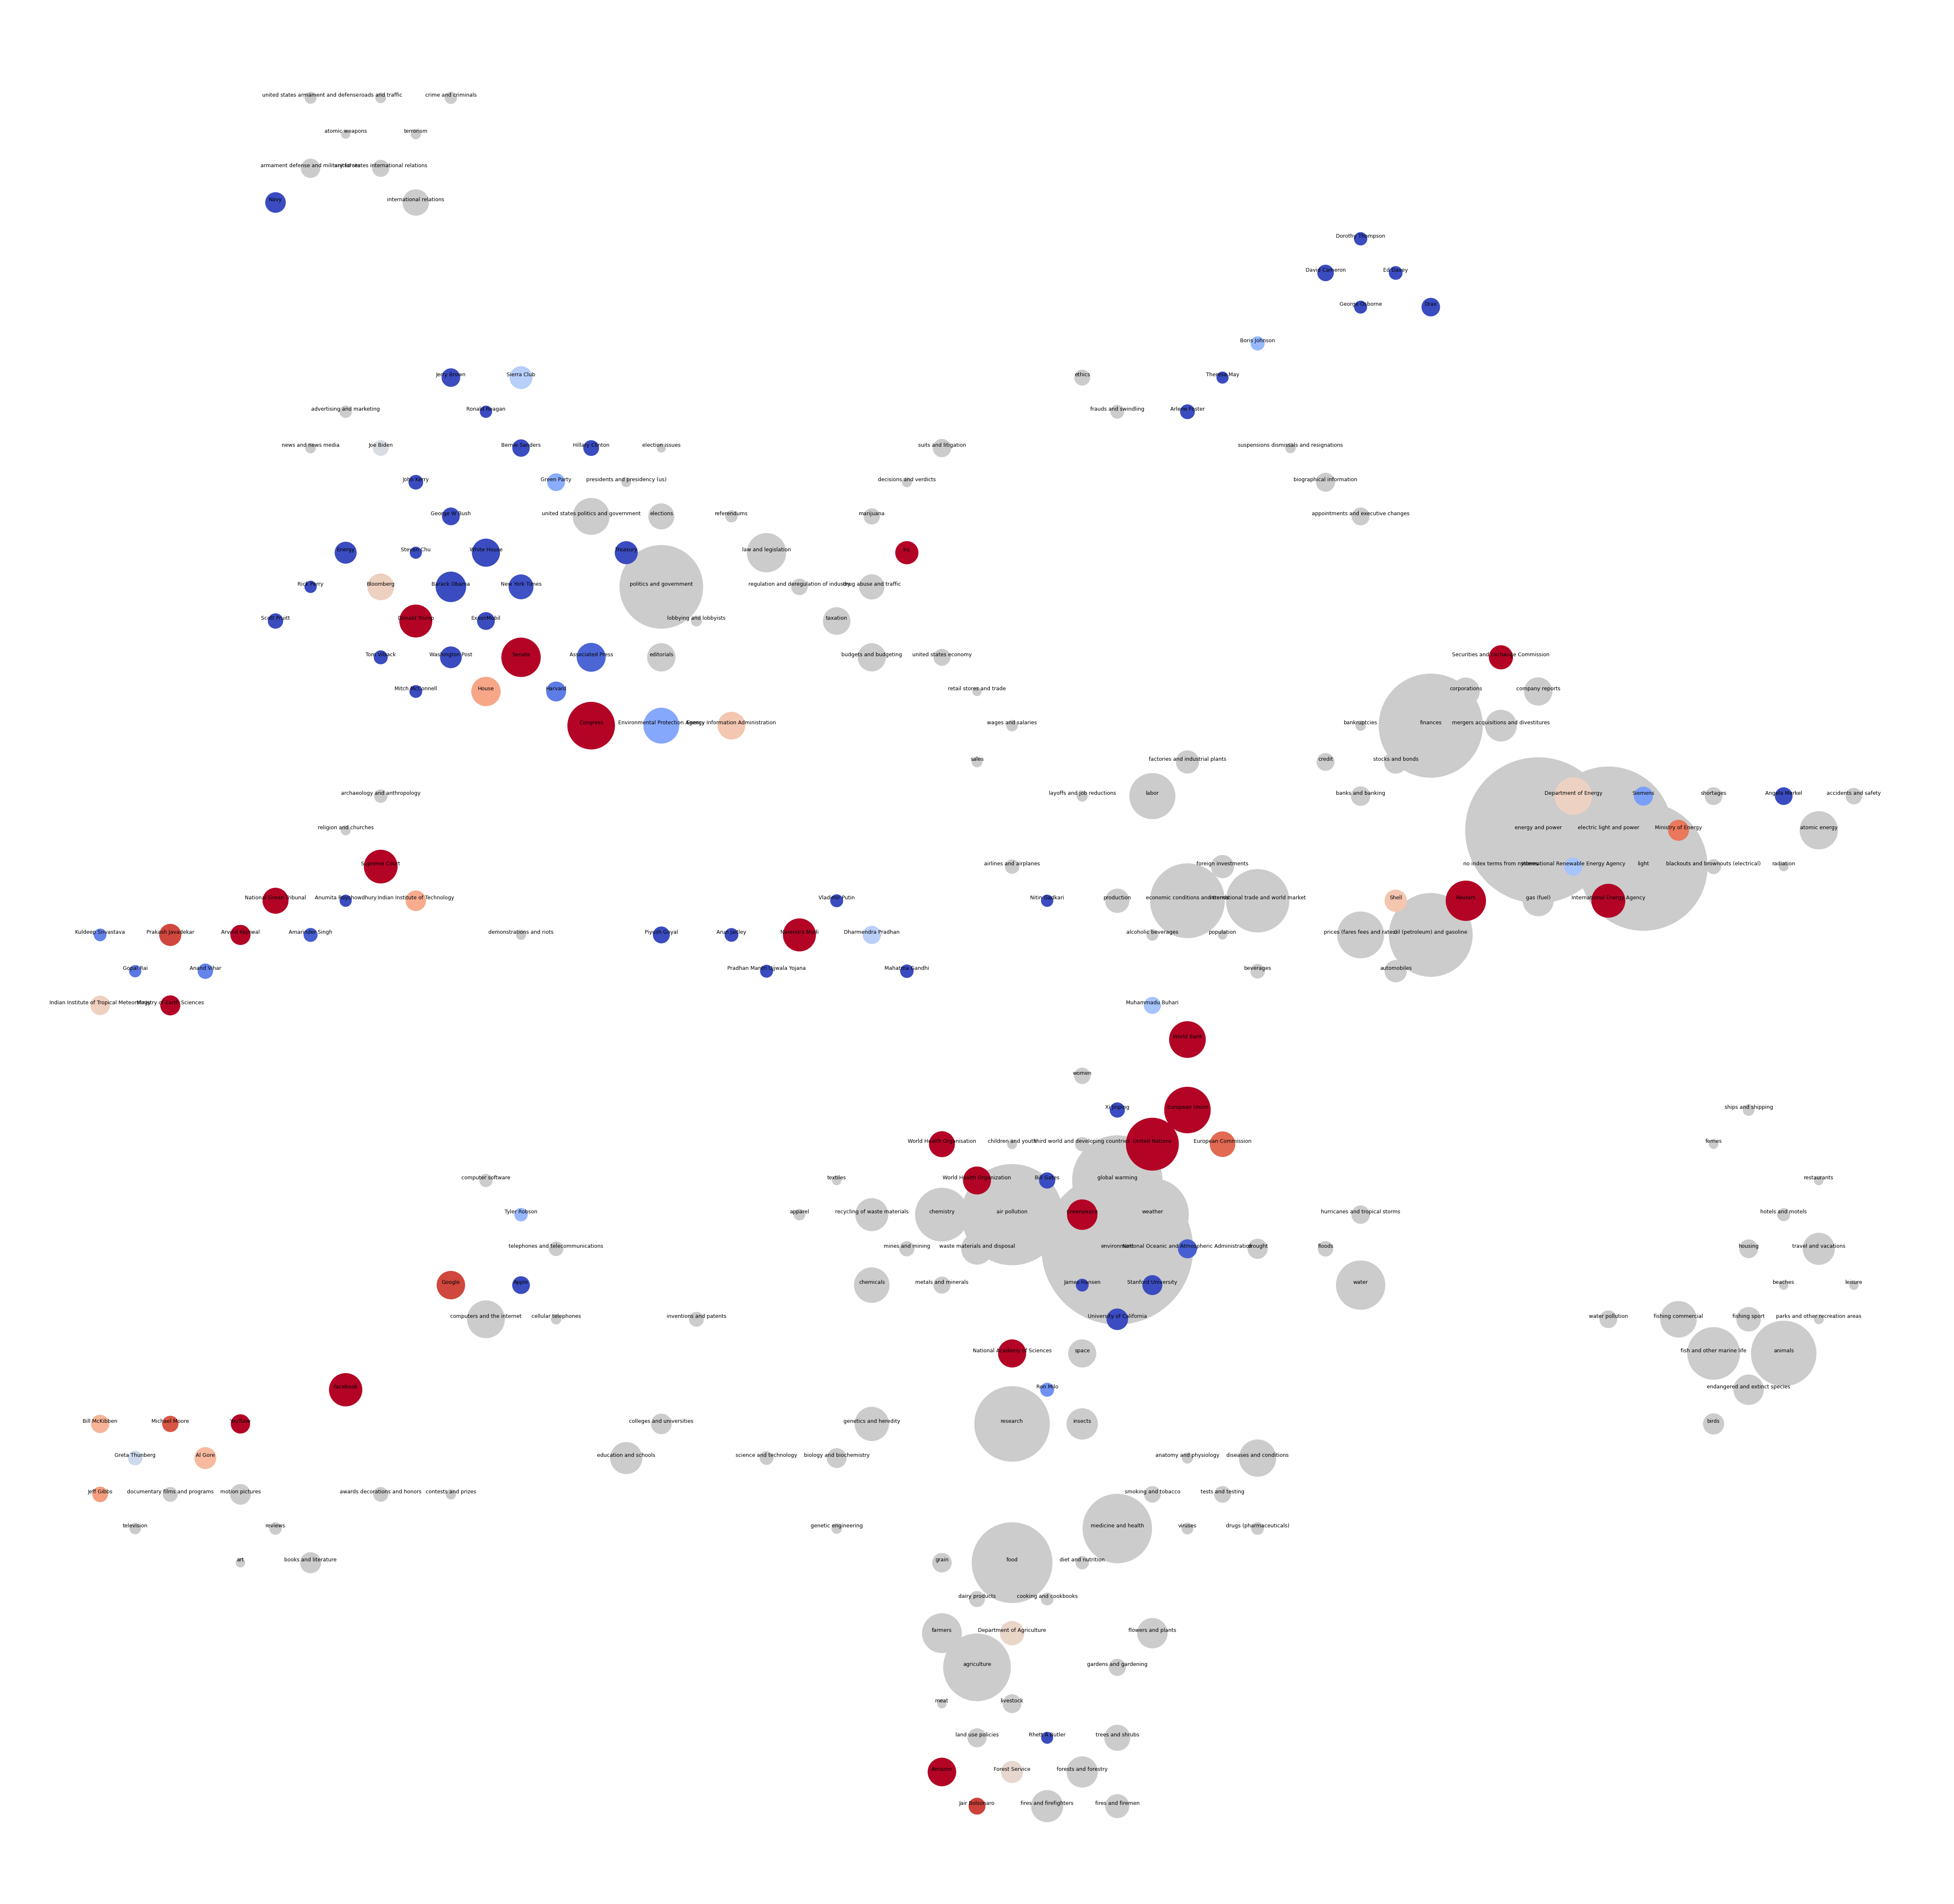

In [121]:
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")

## Clustering

In [122]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=1,  
    min_cluster_size=3, # 2 — which means 3 elements — is the smallest cluster size
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=10, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities['cluster'] = '-1' # Reset

def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_
    
    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, 'cluster'] = prefix + str(clusters[count])
        else:
            entities.loc[index, 'cluster'] = str(clusters[count])
    
cluster_computing(entities.loc[(entities["type"] != "subject") & (entities["slope"] > 0)], 'p_', entities)
cluster_computing(entities.loc[(entities["type"] != "subject") & (entities["slope"] < 0)], 'n_', entities)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
1509,blackouts and brownouts (electrical),subject,59,-7.992283,#CCCCCC,836,540,-1,"{2011: 3, 2012: 1, 2013: 6, 2014: 6, 2015: 4, ...",[http://www.ibtimes.co.uk/articles/452192/2013...,[Greenpeace Activists Protest over Severe Powe...,"[light, budgets and budgeting, Shiela Dixit, p...",0.007719


{'p_2', 'n_2', 'n_0', 'p_1', 'p_4', 'n_1', 'p_5', 'n_3', 'p_3', 'p_0', 'n_4'}


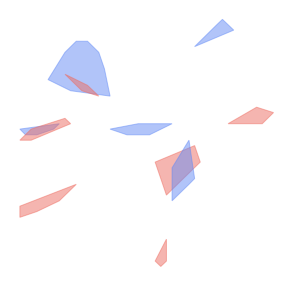

In [125]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())
clusters.remove("-1")  # Remove -1

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = entities.loc[entities["cluster"] == cluster]  # Rows
    
    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)
    
    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])
    
    if cluster[0] == 'p':
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    else:
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


[580 596 596 548 516 500 484 612] [410 426 459 377 312 393 410 410]


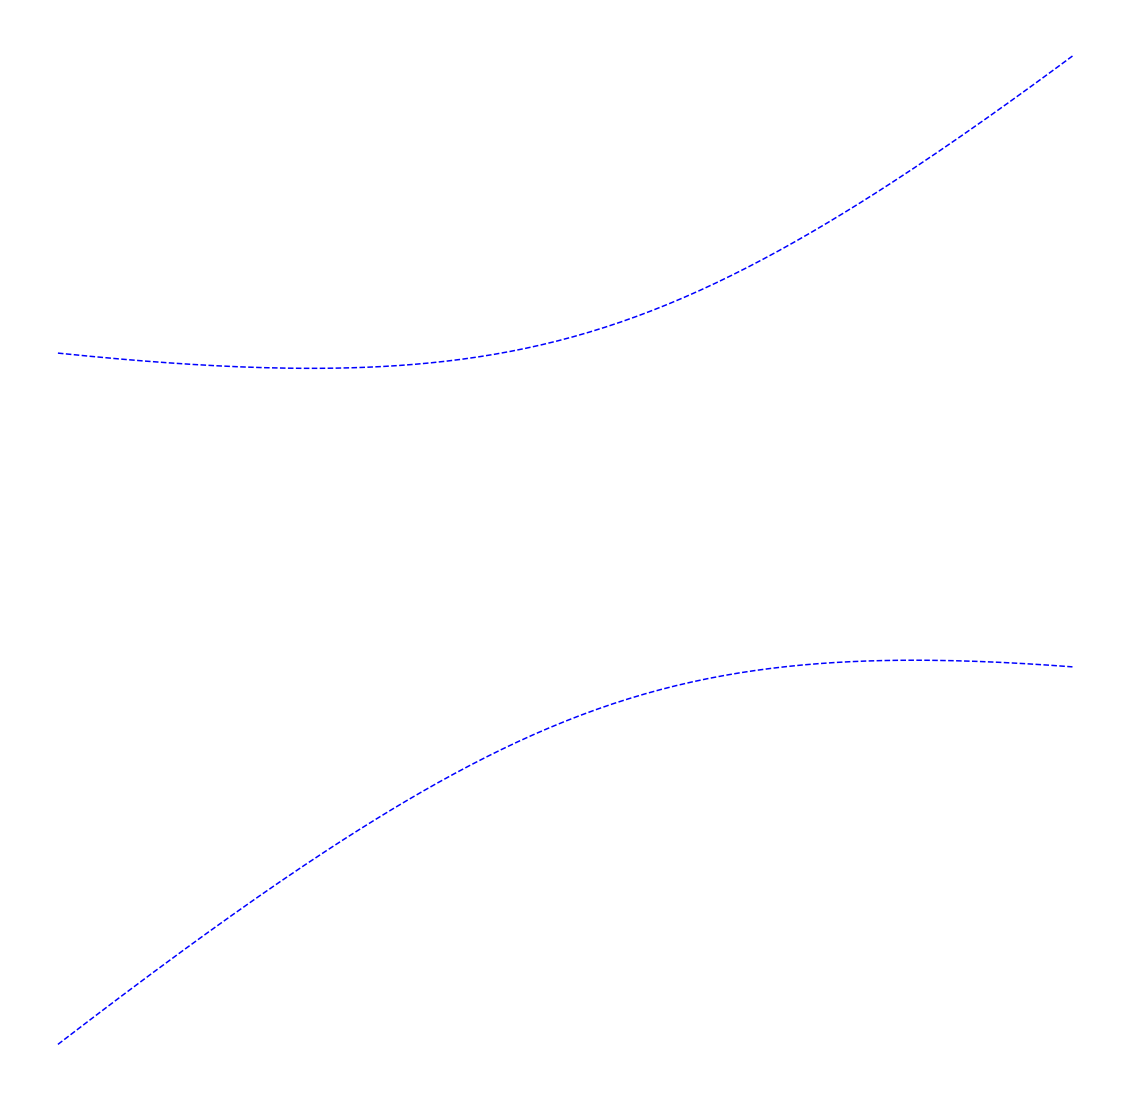

In [154]:
plt.figure(figsize=(20, 20))
plt.axis("off")

clusters = set(entities["cluster"].tolist())
clusters.remove("-1")  # Remove -1

# print(clusters)

for counter, cluster in enumerate(clusters):

    if counter == 0:

        x = np.empty((0, 1), dtype=int)
        y = np.empty((0, 1), dtype=int)

        # points = []  # Points
        rows = entities.loc[entities["cluster"] == cluster]  # Rows
        
        for index, row in rows.iterrows():
            # points.append(, row["y"]])
            x = np.append(x,row["x"])
            y = np.append(y,row["y"])
        # points = np.array(points)

        print(x, y)
    
        # example data
        # x = np.array([4.0,2.5,3.2,5.8,7.4,4.4,8.3,8.5])
        # y = np.array([2.1,4.0,1.5,6.3,5.0,5.8,8.1,7.1])
        
        # fit a curve to the data using a least squares 1st order polynomial fit
        z = np.polyfit(x,y,1)
        p = np.poly1d(z)
        fit = p(x)
        
        # get the coordinates for the fit curve
        c_y = [np.min(fit), np.max(fit)]
        c_x = [np.min(x), np.max(x)]
        
        # predict y values of origional data using the fit
        p_y = z[0] * x + z[1]
        
        # calculate the y-error (residuals)
        y_err = y -p_y
        
        # create series of new test x-values to predict for
        p_x = np.arange(np.min(x),np.max(x)+1,1)
        
        # now calculate confidence intervals for new test x-series
        # mean_x = np.mean(x)         # mean of x
        # n = len(x)              # number of samples in origional fit
        # t = 2.31                # appropriate t value (where n=9, two tailed 95%)
        # s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals
        
        # confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/
        #             ((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
        
        # # now predict y based on test x-values
        # p_y = z[0]*p_x+z[0]
        
        # # get lower and upper confidence limits based on predicted y and confidence intervals
        # lower = p_y - abs(confs)
        # upper = p_y + abs(confs)
        
        # # plot sample data
        # plt.plot(x,y,'bo',label='Sample observations')
        
        # # plot line of best fit
        # plt.plot(c_x,c_y,'r-',label='Regression line')
        
        # plot confidence limits
        plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
        plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')



# Save

In [124]:
entities.to_csv("src/data/entities.csv", index=False)